# Lab4: Quantize DeiT

### Setup

In [ ]:
# install the newest version of torch, torchvision, and timm
!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata timm
!pip3 install torch torchaudio torchvision torchtext torchdata timm

In [2]:
import numpy as np
import torch
from torch import nn
import os
from tqdm.auto import tqdm

from torchvision import datasets, transforms
from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader

from torch.export import export, ExportedProgram
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights
from torch._export import capture_pre_autograd_graph
from torch.ao.quantization.quantize_pt2e import convert_pt2e, prepare_pt2e, prepare_qat_pt2e
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    get_symmetric_quantization_config,
    XNNPACKQuantizer,
)

def evaluate_model(model, data_loader, device):
    # model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')


torch.cuda.is_available()

/home/shigon/miniconda3/envs/executorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [3]:
def data_loader_to_list(data_loader):

    new_data_loader = []

    for i, data in enumerate(data_loader):
        if i >= 256:
            break
        new_data_loader.append(data)

    return new_data_loader

In [4]:
def build_dataset_CIFAR100(is_train, data_path):
    transform = build_transform(is_train)
    dataset = datasets.CIFAR100(data_path, train=is_train, transform=transform, download=True)
    nb_classes = 100
    return dataset, nb_classes

def build_transform(is_train):
    input_size = 224
    eval_crop_ratio = 1.0

    resize_im = input_size > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=input_size,
            is_training=True,
            color_jitter=0.3,
            auto_augment='rand-m9-mstd0.5-inc1',
            interpolation='bicubic',
            re_prob=0.0,
            re_mode='pixel',
            re_count=1,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(
                input_size, padding=4)
        return transform

    t = []
    if resize_im:
        size = int(input_size / eval_crop_ratio)
        t.append(
            transforms.Resize(size, interpolation=3),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)

def prepare_data(batch_size):
    train_set, nb_classes = build_dataset_CIFAR100(is_train=True, data_path='./data')
    test_set, _ = build_dataset_CIFAR100(is_train=False, data_path='./data')

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, test_loader, nb_classes

def train_one_epoch(model, criterion, optimizer, data_loader, device):

    cnt = 0

    for image, target in tqdm(data_loader):
        cnt += 1
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return

## Part1: Simple Quantization Pipeline (0%)

Below is a naive pipeline of quantizing DeiT-S. You may need to modify the pipeline or build your own later on.

[**use_reference_representation=False** in **convert_pt2e()** represents fake quant (matmul using fp32).](https://pytorch.org/tutorials/prototype/pt2e_quant_ptq_static.html#convert-the-calibrated-model-to-a-quantized-model)

However when the variable is set to True, the execution speed becomes extremely slow.

In this lab, it is just fine to set **use_reference_representation=False**.

In [35]:
def quantize_ptq_model(model: nn.Module, data_loader, per_channel=False, quantizer=None) -> None:
    _dummy_input_data = (next(iter(data_loader))[0],)
    model.eval()
    model = capture_pre_autograd_graph(model, _dummy_input_data)

    if quantizer is None:
        print("Using default XNNPACKQuantizer")
        quantizer = XNNPACKQuantizer()
        quantization_config = get_symmetric_quantization_config(is_per_channel=per_channel, is_qat=False)
        quantizer.set_global(quantization_config)
    # prepare_pt2e folds BatchNorm operators into preceding Conv2d operators, and inserts observers in appropriate places in the model.
    model = prepare_pt2e(model, quantizer)

    # model(*_dummy_input_data)
    #get 128 input data for calibration
    for i, (image, _) in enumerate(data_loader):
        if i >= 128:
            break
        model(image)

    model = convert_pt2e(model, use_reference_representation=False)

    return model

In [7]:
batch_size = 1
model = torch.load('0.9099_deit3_small_patch16_224.pth', map_location='cpu')
train_loader, test_loader, nb_classes = prepare_data(batch_size)

simple_test_loader = data_loader_to_list(test_loader)

# evaluate before quantization
print('Before quantization:')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print_size_of_model(model)
# evaluate_model(model, test_loader, device) # acc: 90.99%
evaluate_model(model, simple_test_loader, device) # for fast testing purpose, this is not the real accuracy

# quantize model
print('Quantizing model...')
model.cpu()
quantized_model = quantize_ptq_model(model, train_loader, per_channel=False)
torch.ao.quantization.move_exported_model_to_eval(quantized_model)

# after quantization
print('After quantization:')
print_size_of_model(quantized_model)
# evaluate_model(quantized_model, test_loader, device) # acc: 82.51%
evaluate_model(quantized_model, simple_test_loader, device) # for fast testing purpose, this is not the real accuracy

Files already downloaded and verified
Files already downloaded and verified
Before quantization:
Size (MB): 86.903222


100%|██████████| 256/256 [00:02<00:00, 86.85it/s] 


Accuracy of the model on the test images: 93.75%
Quantizing model...
After quantization:
Size (MB): 21.938609


100%|██████████| 256/256 [00:05<00:00, 44.10it/s]

Accuracy of the model on the test images: 86.328125%


86.328125

#### To export and save quantized model

In [7]:
quantized_model_path = "deits_quantized.pth"
quantized_model.cpu()

cpu_example_inputs = (next(iter(train_loader))[0], )
quantized_ep = torch.export.export(quantized_model, cpu_example_inputs)
torch.export.save(quantized_ep, quantized_model_path)

#### To load back the exported quantized model

In [28]:
loaded_quantized_ep = torch.export.load(quantized_model_path)
loaded_quantized_model = loaded_quantized_ep.module()
loaded_quantized_model.cpu()
device = torch.device("cpu")
# acc = evaluate_model(loaded_quantized_model, test_loader, device)
acc = evaluate_model(loaded_quantized_model, simple_test_loader, device) # for fast testing purpose, this is not the real accuracy

100%|██████████| 256/256 [00:14<00:00, 17.92it/s]

Accuracy of the model on the test images: 85.546875%


### Evaluation

In [29]:
pt2e_quantized_model_file_path = "deits_quantized.pth"
loaded_quantized_ep = torch.export.load(pt2e_quantized_model_file_path)
loaded_quantized_model = loaded_quantized_ep.module()
import time
device = torch.device("cpu") # since we are using the quantized model, we should use cpu
start_time = time.time()

acc = evaluate_model(loaded_quantized_model, test_loader, device)
exec_time = start_time - time.time()
model_size = print_size_of_model(loaded_quantized_model)

  1%|          | 83/10000 [00:04<09:18, 17.77it/s]


KeyboardInterrupt: 

# Below are some tools that may be useful in this lab:

## Profiling Models

The code below profiles your model, and generates a trace file for you to find out what is going on in your model throughout the execution.

The generated trace file will be named *(test_trace_*.json)*, in the same directory as the notebook. To visualize, go to page [chrome://tracing](chrome://tracing) in either Chrome or Edge browser, then upload the trace file.

In [30]:
# profile model
from torch.profiler import profile, record_function, ProfilerActivity

# ## Default way to use profiler
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
#     for _ in range(10):
#         a = torch.square(torch.randn(10000, 10000).cuda())

# prof.export_chrome_trace("trace.json")

def torch_profile(model, input_data, device):
  ## With warmup and skip
  # https://pytorch.org/docs/stable/profiler.html

  # Non-default profiler schedule allows user to turn profiler on and off
  # on different iterations of the training loop;
  # trace_handler is called every time a new trace becomes available
  def trace_handler(prof):
    print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("./test_trace_" + str(prof.step_num) + ".json")

  with torch.profiler.profile(
    activities=[
      torch.profiler.ProfilerActivity.CPU,
      torch.profiler.ProfilerActivity.CUDA,
    ],

    # In this example with wait=1, warmup=1, active=2, repeat=1,
    # profiler will skip the first step/iteration,
    # start warming up on the second, record
    # the third and the forth iterations,
    # after which the trace will become available
    # and on_trace_ready (when set) is called;
    # the cycle repeats starting with the next step
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=2, repeat=1),
    on_trace_ready=trace_handler
    # on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
    # used when outputting for tensorboard
    ) as p:
      for data in input_data:
        model(data.to(device))
        # send a signal to the profiler that the next iteration has started
        p.step()

In [31]:
dummy_input_data = [next(iter(test_loader))[0] for _ in range(3)]
device = torch.device("cpu")

# profile quantized model
torch_profile(loaded_quantized_model, dummy_input_data, device)

INFO:2024-05-13 08:32:31 392221:392221 init.cpp:169] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti
STAGE:2024-05-13 08:32:31 392221:392221 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-13 08:32:31 392221:392221 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-13 08:32:31 392221:392221 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        ProfilerStep*         8.37%       5.088ms       100.00%      60.780ms      30.390ms             2  
                                             aten::to         1.96%       1.190ms         9.34%       5.678ms       3.694us          1537  
            quantized_decomposed::quantize_per_tensor         4.16%       2.531ms        19.85%      12.067ms      68.175us           177  
                                            aten::mul         9.87%       5.996ms        11.63%       7.066ms      14.813us           477  
                    

## To obtain specific model layers

In [6]:
def match_string(string, match_list, match_prefix=False, match_suffix=False):
    if match_prefix:
        return any(string.startswith(s) for s in match_list)
    elif match_suffix:
        return any(string.endswith(s) for s in match_list)
    else:
        return any(s in string for s in match_list)

def get_model_layers(model, match_names=None, match_types=None, prefix=''):
    matching_layers = []
    for name, module in model.named_modules():
        if match_names is None or match_string(name, match_names):
            if match_types is None or match_string(type(module).__name__, match_types):
                matching_layers.append((f'{prefix}{name}', module))
    return matching_layers

layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])

print(block0_layers)

[('blocks.0.attn.qkv', Linear(in_features=384, out_features=1152, bias=True)), ('blocks.0.mlp.fc1', Linear(in_features=384, out_features=1536, bias=True)), ('blocks.0.mlp.fc2', Linear(in_features=1536, out_features=384, bias=True))]


## To capture the output of each layer


In [7]:
class HookHandler:
    def __init__(self):
        self.handlers = []

    def __del__(self):
        self.remove_hooks()

    def _generate_hook(self, apply_func, key, layer_data_dict: dict):
        def hook_fn(model, input, output):
            nonlocal layer_data_dict
            layer_data_dict[key] = apply_func(
                output, layer_data_dict.get(key, None))
        return hook_fn

    def _bind_hooks(self, apply_layers, apply_func, layer_data_dict: dict):
        for name, module in apply_layers:
            hook_fn = self._generate_hook(apply_func, name, layer_data_dict)
            self.handlers.append(module.register_forward_hook(hook_fn))

    def create_hooks(self, apply_layers, apply_func, layer_data_dict: dict):
        self._bind_hooks(apply_layers, apply_func, layer_data_dict)

    def remove_hooks(self):
        for handle in self.handlers:
            handle.remove()
        self.handlers = []

def absmax(data, axis=None):
    p_data = data.max(axis=axis)
    n_data = data.min(axis=axis)
    return np.where(abs(p_data) > abs(n_data), p_data, n_data)

def get_flat_act_func(new_val: torch.Tensor, _):
    return new_val.cpu().detach().numpy().flatten()


def get_act_func(new_val: torch.Tensor, _):
    return new_val.cpu().detach().numpy()


def get_avg_act_func(new_val: torch.Tensor, existing_val):
    if existing_val is None:
        avg = new_val.cpu().detach().numpy().sum(axis=0) / total_cnt
        total_cnt = new_val.shape[0]

    else:
        total_cnt, avg = existing_val.get("total_cnt"), existing_val.get("value")
        avg = (avg * total_cnt + new_val.cpu().detach().numpy().sum(axis=0)) / (total_cnt + new_val.shape[0])
        total_cnt += new_val.shape[0]

    return {"total_cnt": total_cnt, "value": avg}

def get_absmax_act_func(new_val: torch.Tensor, existing_val):
    new_absmax = absmax(new_val.cpu().detach().numpy(), axis=0)
    if existing_val is None:
        value = new_absmax
    else:
        value = absmax(np.stack([existing_val, new_absmax], axis=0), axis=0)
    return value

In [19]:
# initialize HookHandler and the dictionary to store the outputs
handler = HookHandler()
layer_outputs = {}

# get the layers you want to record
layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])

# create hooks for the layers (<layers>, <hook function>, <dictionary to store the outputs>)
handler.create_hooks(block0_layers, get_act_func, layer_outputs)

# calibrate the model and record the outputs
model.cpu()
with torch.autocast(device_type="cuda"):
    for i, (image, _) in enumerate(train_loader):
        if i >= 128: break
        model(image)

# remove the hooks
handler.remove_hooks()

print(layer_outputs)

{'blocks.0.attn.qkv': array([[[ 1.5987055 ,  0.2754088 ,  0.18741053, ...,  0.08069375,
          0.13131575,  0.15566228],
        [-3.3788047 , -0.13452035, -0.7507348 , ..., -0.06122828,
         -6.5811133 ,  0.25142893],
        [-3.3544254 , -0.11638433, -0.69685805, ..., -0.04096967,
         -6.4842296 ,  0.27277383],
        ...,
        [-1.1585095 ,  0.04483114, -0.29913673, ...,  2.8575854 ,
         -0.8982764 , -0.32153058],
        [-1.3124247 ,  0.05002201, -0.29151756, ...,  2.8137114 ,
         -1.1338345 , -0.5336081 ],
        [-1.4511354 ,  0.0390073 , -0.3303124 , ...,  2.786714  ,
         -1.5323292 , -0.7199548 ]]], dtype=float32), 'blocks.0.mlp.fc1': array([[[-9.7171521e-01, -1.4992098e+00, -1.5089514e+00, ...,
         -1.1206180e-02, -1.2134457e+00, -1.2449870e+00],
        [-1.1723194e+00, -1.6098838e+00, -1.3632097e+00, ...,
         -2.5585294e-05, -1.4280846e+00, -1.3806914e+00],
        [-1.1390189e+00, -1.6128876e+00, -1.4057963e+00, ...,
         -1.4

## Model architecture

In [44]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

# Number of parameters in each layer

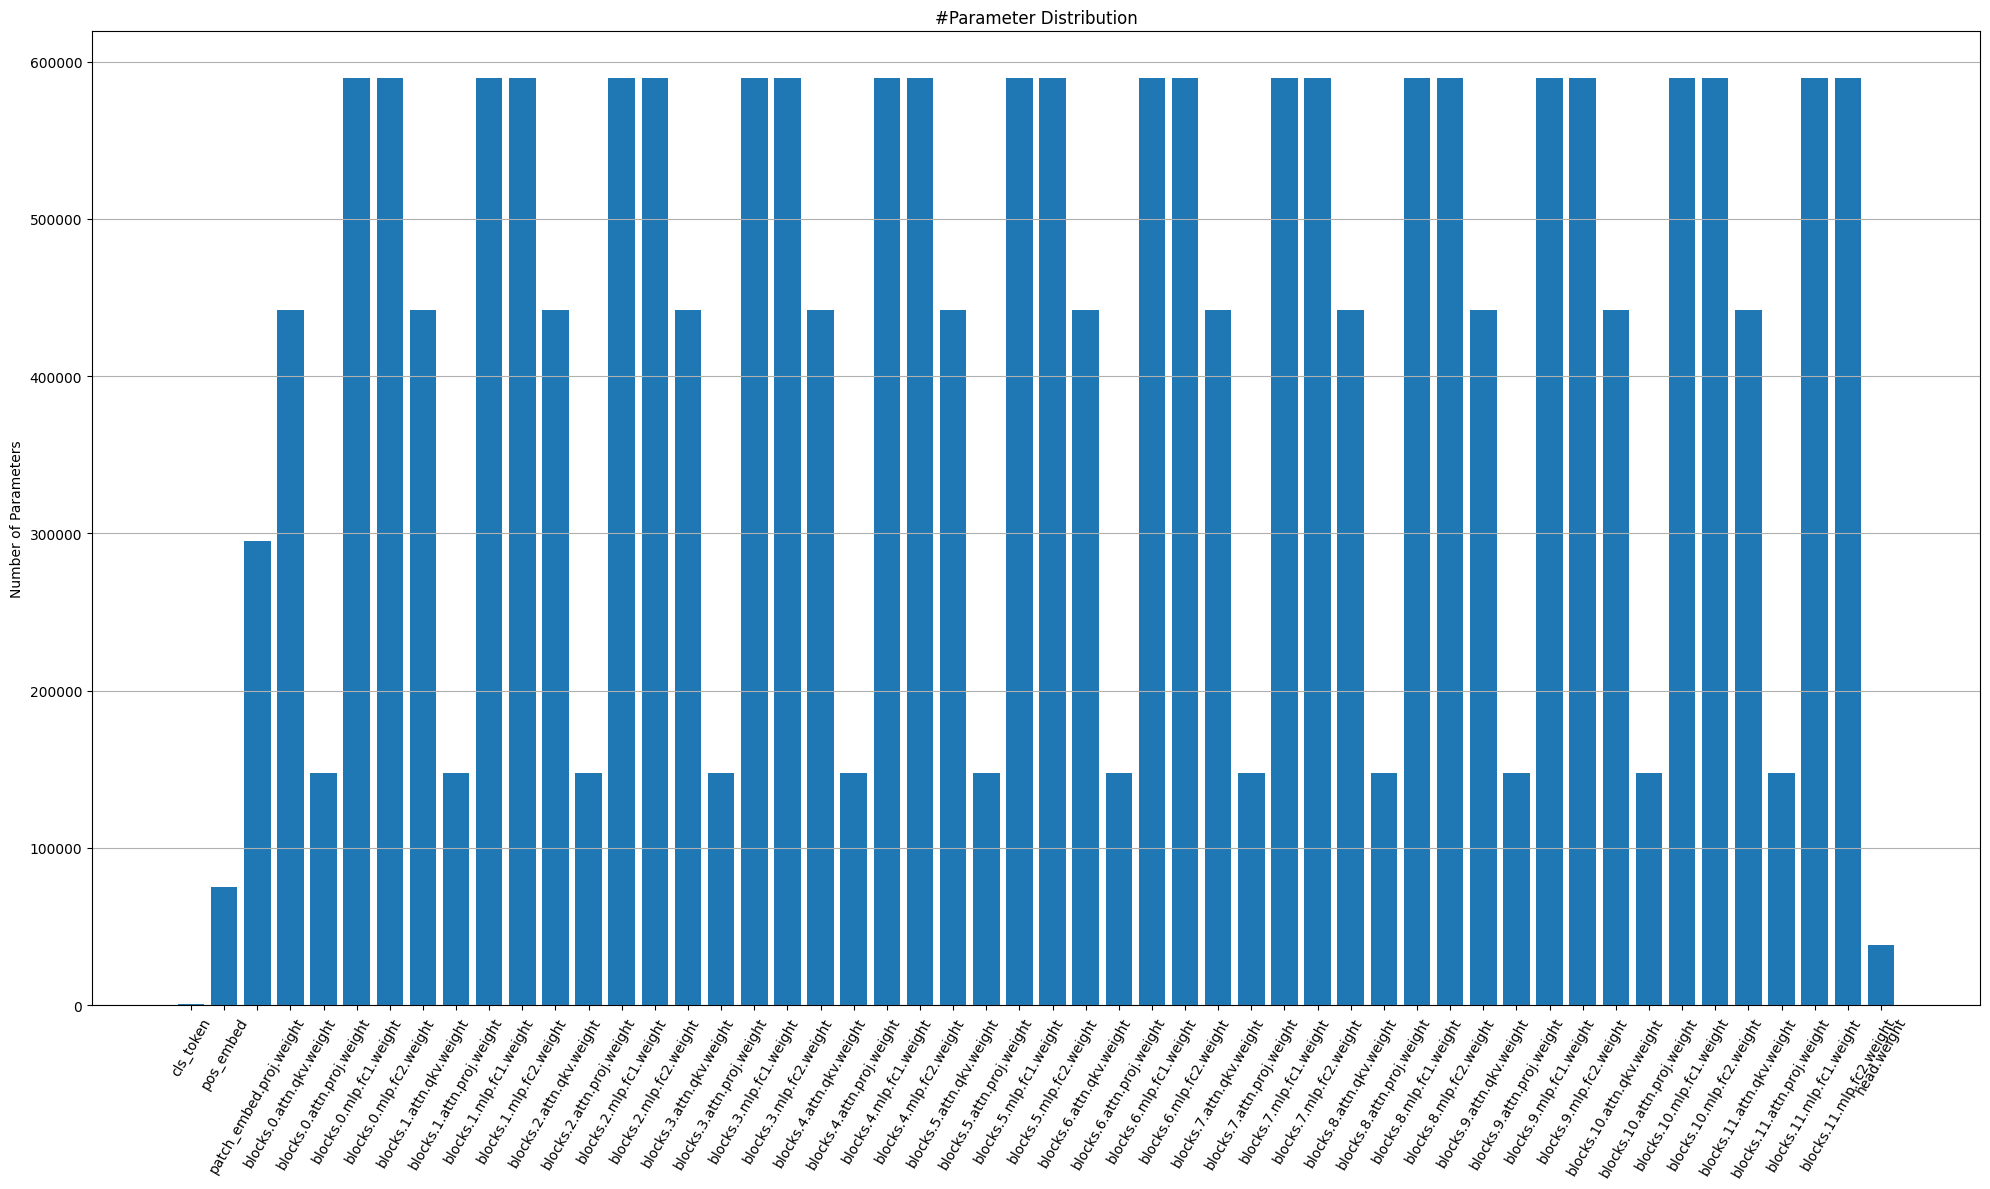

In [49]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(20, 12))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Weight distribution

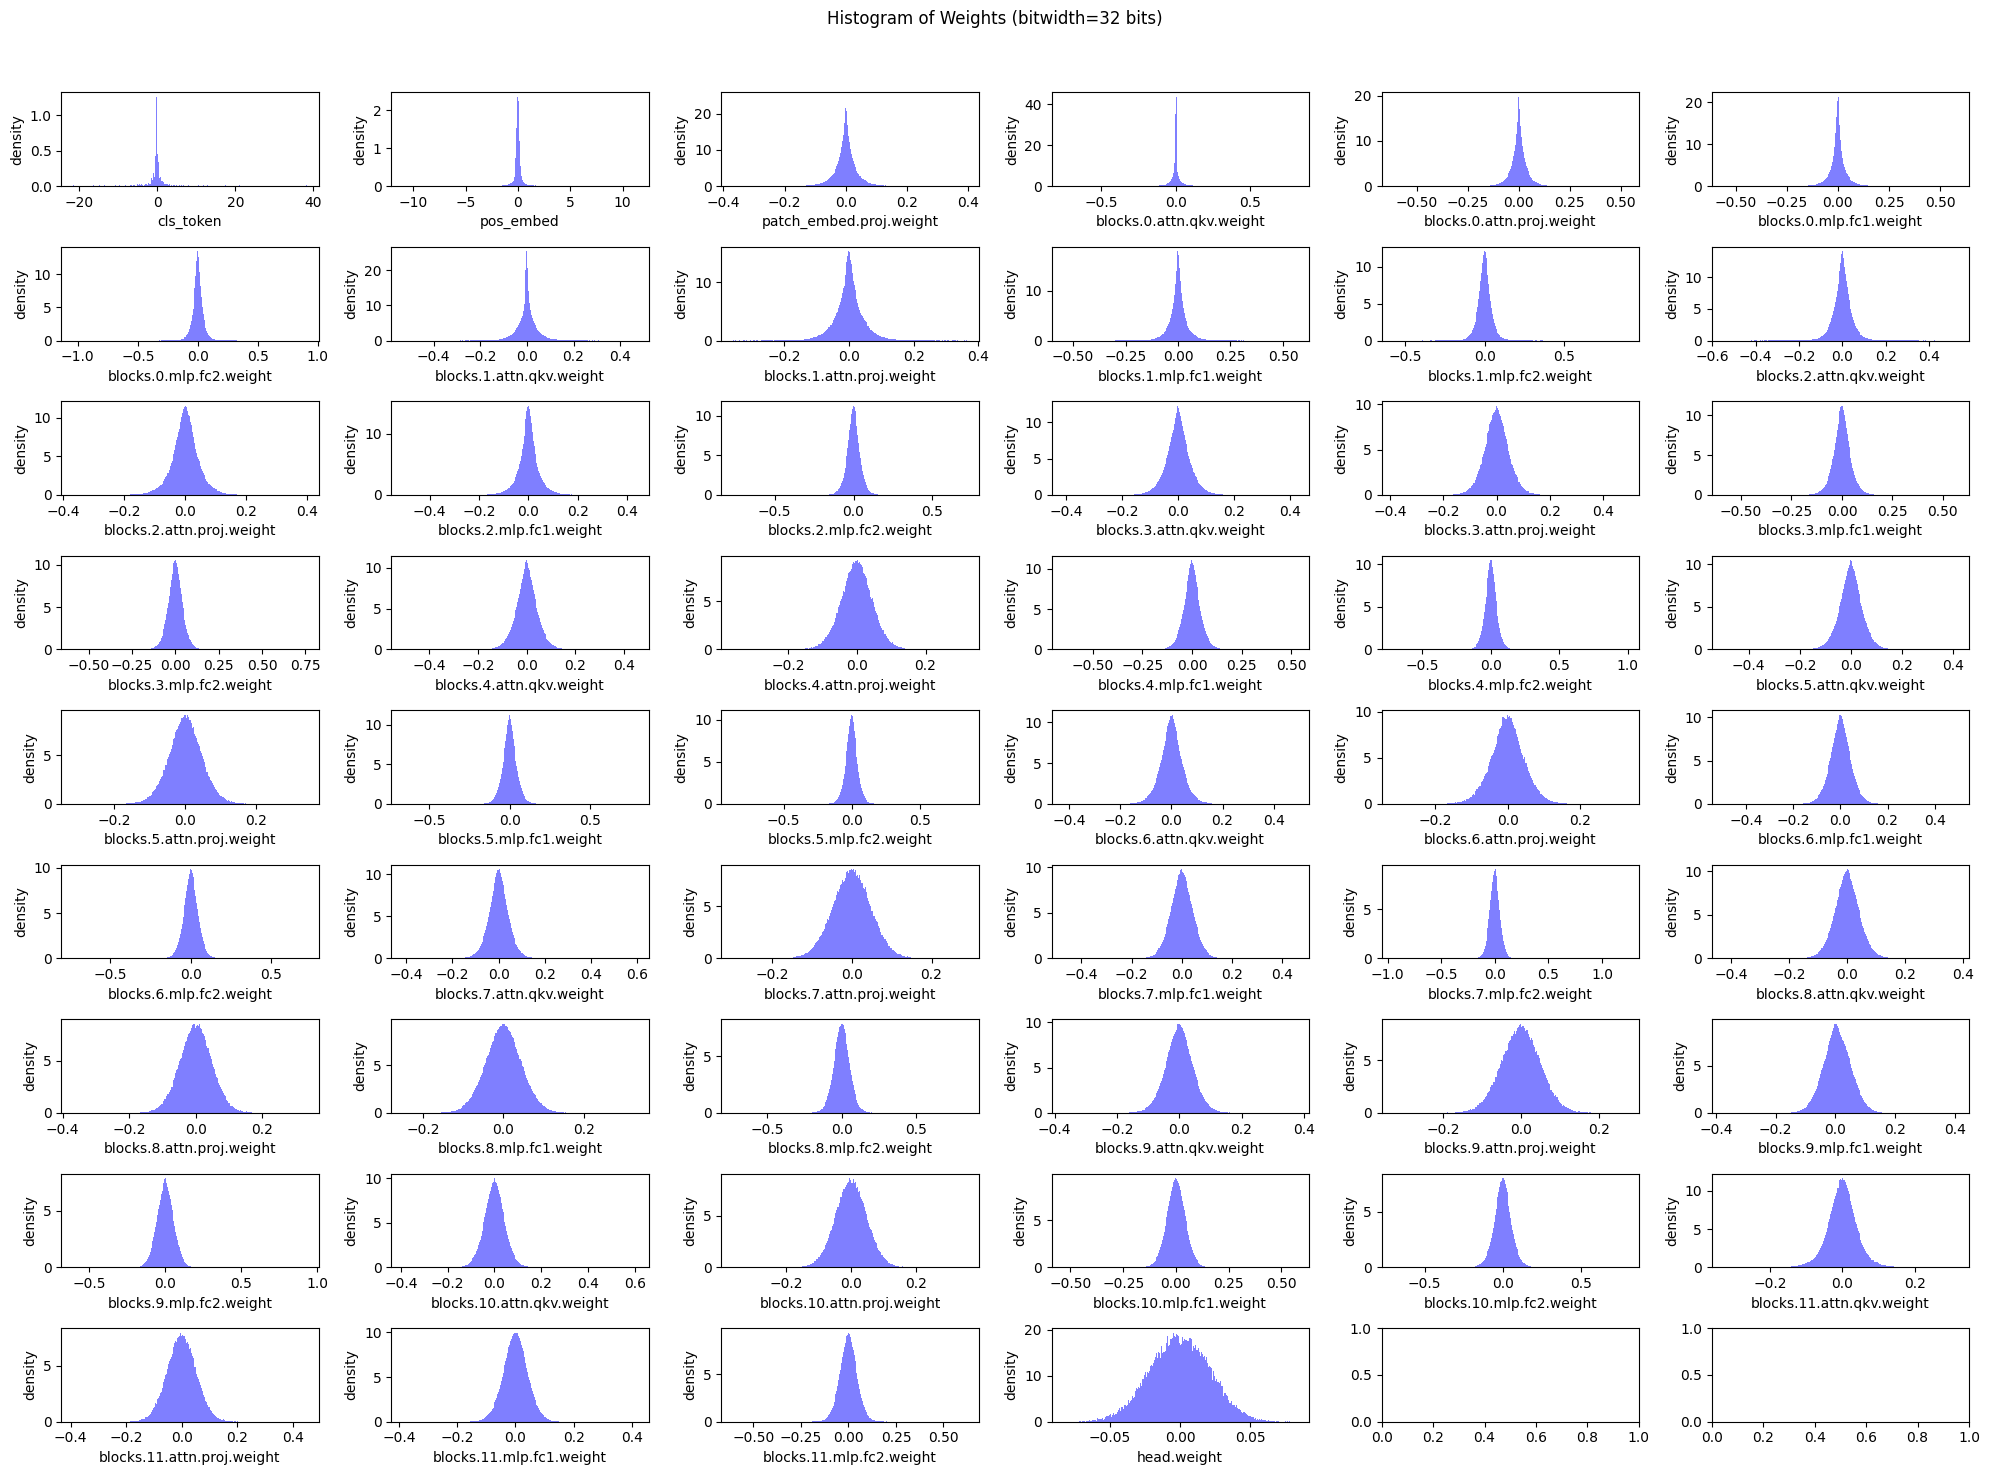

In [ ]:
import matplotlib.pyplot as plt
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(9,6, figsize=(20, 15))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

## To ignore specific layers for quantization:
([xnnpack source code](https://github.com/pytorch/pytorch/blob/main/torch/ao/quantization/quantizer/xnnpack_quantizer.py\), also you can try messing around with the Observer classes)

In [11]:
# module names
print([name for name, _ in model.named_modules()])    

['', 'patch_embed', 'patch_embed.proj', 'patch_embed.norm', 'pos_drop', 'patch_drop', 'norm_pre', 'blocks', 'blocks.0', 'blocks.0.norm1', 'blocks.0.attn', 'blocks.0.attn.qkv', 'blocks.0.attn.q_norm', 'blocks.0.attn.k_norm', 'blocks.0.attn.attn_drop', 'blocks.0.attn.proj', 'blocks.0.attn.proj_drop', 'blocks.0.ls1', 'blocks.0.drop_path1', 'blocks.0.norm2', 'blocks.0.mlp', 'blocks.0.mlp.fc1', 'blocks.0.mlp.act', 'blocks.0.mlp.drop1', 'blocks.0.mlp.norm', 'blocks.0.mlp.fc2', 'blocks.0.mlp.drop2', 'blocks.0.ls2', 'blocks.0.drop_path2', 'blocks.1', 'blocks.1.norm1', 'blocks.1.attn', 'blocks.1.attn.qkv', 'blocks.1.attn.q_norm', 'blocks.1.attn.k_norm', 'blocks.1.attn.attn_drop', 'blocks.1.attn.proj', 'blocks.1.attn.proj_drop', 'blocks.1.ls1', 'blocks.1.drop_path1', 'blocks.1.norm2', 'blocks.1.mlp', 'blocks.1.mlp.fc1', 'blocks.1.mlp.act', 'blocks.1.mlp.drop1', 'blocks.1.mlp.norm', 'blocks.1.mlp.fc2', 'blocks.1.mlp.drop2', 'blocks.1.ls2', 'blocks.1.drop_path2', 'blocks.2', 'blocks.2.norm1', 'blo

In [47]:
# Replace functions XNNPackQuantizer uses for annotation.

def get_module_names(name):
    names = name.split(".")
    return [".".join(names[i:]) for i in reversed(range(len(names)))]

def parse_string(name):
    if name.startswith("L"): return name[10:]
    split_getattr = name.split(")")
    ig_left = split_getattr[0].split("L['self'].")[-1].split(",")[0]
    ig_right = split_getattr[0].split(", '")[-1][:-1]
    return ig_left + "." + str(ig_right) + split_getattr[1]

def is_name_in_ignore_list(name, IGNORE_LIST):
    return name in IGNORE_LIST

def name_not_in_ignore_list(n, IGNORE_LIST) -> bool:
    nn_module_stack = n.meta.get("nn_module_stack", {})
    names = [n for n, klass in nn_module_stack.values()]
    if len(names) == 0:
        return True

    names = get_module_names(parse_string(names[-1]))
    set1 = set(names)
    set2 = set(IGNORE_LIST)
    # if len(set1.intersection(set2)) == 0:
    #     print("DEBUG: ", names)
    return len(set1.intersection(set2)) == 0

def get_module_name_filter(module_name: str, IGNORE_LIST):
    def module_name_filter(n) -> bool:
        nn_module_stack = n.meta.get("nn_module_stack", {})
        names = [n for n, klass in nn_module_stack.values()]
        if len(names) == 0:
            return False

        names = get_module_names(parse_string(names[-1]))
        return (module_name in names) and name_not_in_ignore_list(n, IGNORE_LIST)
    return module_name_filter


def get_module_type_filter(tp, IGNORE_LIST):
    def module_type_filter(n) -> bool:
        nn_module_stack = n.meta.get("nn_module_stack", {})
        types = [t for _, t in nn_module_stack.values()]
        return (tp in types) and name_not_in_ignore_list(n, IGNORE_LIST)

    return module_type_filter


def get_not_module_type_or_name_filter(
    tp_list, module_name_list, IGNORE_LIST
):
    module_type_filters = [get_module_type_filter(tp) for tp in tp_list]
    module_name_list_filters = [get_module_name_filter(m) for m in module_name_list]

    def not_module_type_or_name_filter(n) -> bool:
        return not any(f(n) for f in module_type_filters + module_name_list_filters) and name_not_in_ignore_list(n, IGNORE_LIST)

    return not_module_type_or_name_filter

class PartialXNNPACKQuantizer(XNNPACKQuantizer): # skips quantizing layers inside the ignore_list
    def __init__(self, ignore_list):
        super().__init__()
        self.ignore_list = ignore_list

    def _annotate_for_static_quantization_config(
        self, model: torch.fx.GraphModule
    ) -> torch.fx.GraphModule:
        print("annotating for static quantization")
        module_name_list = list(self.module_name_config.keys())
        for module_name, config in self.module_name_config.items():
            self._annotate_all_static_patterns(
                model, config, get_module_name_filter(module_name, self.ignore_list)
            )

        tp_list = list(self.module_type_config.keys())
        for module_type, config in self.module_type_config.items():
            self._annotate_all_static_patterns(
                model, config, get_module_type_filter(module_type, self.ignore_list)
            )

        self._annotate_all_static_patterns(
            model,
            self.global_config,
            get_not_module_type_or_name_filter(tp_list, module_name_list, self.ignore_list),
        )
        return model

    def _annotate_for_dynamic_quantization_config(
        self, model: torch.fx.GraphModule
    ) -> torch.fx.GraphModule:
        print("annotating for dynamic quantization")
        module_name_list = list(self.module_name_config.keys())
        for module_name, config in self.module_name_config.items():
            self._annotate_all_dynamic_patterns(
                model, config, get_module_name_filter(module_name, self.ignore_list)
            )

        tp_list = list(self.module_type_config.keys())
        for module_type, config in self.module_type_config.items():
            self._annotate_all_dynamic_patterns(
                model, config, get_module_type_filter(module_type, self.ignore_list)
            )

        self._annotate_all_dynamic_patterns(
            model,
            self.global_config,
            get_not_module_type_or_name_filter(tp_list, module_name_list, self.ignore_list),
        )
        return model

# quantizer = XNNPACKQuantizer()
ignore_list = [name for name, _ in model.named_modules()]

qkv_list = [name for name, _ in model.named_modules() if 'qkv' in name]
fc_list = [name for name, _ in model.named_modules() if 'fc' in name]
# ignore_list = [name for name in ignore_list if name not in qkv_list]
ignore_list = [name for name in ignore_list if name not in fc_list]
print(ignore_list)
quantizer = PartialXNNPACKQuantizer(ignore_list=ignore_list) # replace XNNPACKQuantizer()
quantizer.set_global(get_symmetric_quantization_config(is_per_channel=False, is_qat=False))

['', 'patch_embed', 'patch_embed.proj', 'patch_embed.norm', 'pos_drop', 'patch_drop', 'norm_pre', 'blocks', 'blocks.0', 'blocks.0.norm1', 'blocks.0.attn', 'blocks.0.attn.q_norm', 'blocks.0.attn.k_norm', 'blocks.0.attn.attn_drop', 'blocks.0.attn.proj', 'blocks.0.attn.proj_drop', 'blocks.0.ls1', 'blocks.0.drop_path1', 'blocks.0.norm2', 'blocks.0.mlp', 'blocks.0.mlp.fc1', 'blocks.0.mlp.act', 'blocks.0.mlp.drop1', 'blocks.0.mlp.norm', 'blocks.0.mlp.fc2', 'blocks.0.mlp.drop2', 'blocks.0.ls2', 'blocks.0.drop_path2', 'blocks.1', 'blocks.1.norm1', 'blocks.1.attn', 'blocks.1.attn.q_norm', 'blocks.1.attn.k_norm', 'blocks.1.attn.attn_drop', 'blocks.1.attn.proj', 'blocks.1.attn.proj_drop', 'blocks.1.ls1', 'blocks.1.drop_path1', 'blocks.1.norm2', 'blocks.1.mlp', 'blocks.1.mlp.fc1', 'blocks.1.mlp.act', 'blocks.1.mlp.drop1', 'blocks.1.mlp.norm', 'blocks.1.mlp.fc2', 'blocks.1.mlp.drop2', 'blocks.1.ls2', 'blocks.1.drop_path2', 'blocks.2', 'blocks.2.norm1', 'blocks.2.attn', 'blocks.2.attn.q_norm', 'bloc

In [48]:
model = torch.load('0.9099_deit3_small_patch16_224.pth', map_location='cpu')
# evaluate before quantization
print('Before quantization:')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print_size_of_model(model)
# evaluate_model(model, test_loader, device) # acc: 90.99%
evaluate_model(model, simple_test_loader, device) # for fast testing purpose, this is not the real accuracy

# quantize model
print('Quantizing model...')
model.cpu()
quantized_model = quantize_ptq_model(model, train_loader, per_channel=False, quantizer=quantizer)
# quantized_model = quantize_ptq_model(model, train_loader, per_channel=False)
torch.ao.quantization.move_exported_model_to_eval(quantized_model)

# after quantization
print('After quantization:')
print_size_of_model(quantized_model)
# evaluate_model(quantized_model, test_loader, device) # acc: 82.51%
evaluate_model(quantized_model, simple_test_loader, device) # for fast testing purpose, this is not the real accuracy

Before quantization:
Size (MB): 86.903222


100%|██████████| 256/256 [00:01<00:00, 212.93it/s]


Accuracy of the model on the test images: 93.75%
Quantizing model...
annotating for static quantization
After quantization:
Size (MB): 70.742129


100%|██████████| 256/256 [00:02<00:00, 125.06it/s]

Accuracy of the model on the test images: 91.40625%


91.40625